In [8]:
from matplotlib import pyplot
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime
import time
from datetime import date, timedelta, datetime, tzinfo
import time

In [2]:
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

22/07/01 17:15:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/01 17:15:58 WARN FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.


In [40]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo, date_trunc('hour', datestamp) as date from storageinfo where datestamp between '2022-06-01 00:00:00' and now()) as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-06-01 00:00:00") \
     .option("upperBound", "2022-06-30 23:59:59") \
     .option("fetchsize", 10000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [5]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,queuedtime,bigint
1,fullsize,bigint
2,storageclass,string
3,connectiontime,bigint
4,action,string
5,cellname,string
6,datestamp,timestamp
7,errorcode,int
8,errormessage,string
9,pnfsid,string


In [37]:
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  988117  Time to execute  0.7260701656341553


In [32]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string, date: timestamp]

Number of entries again =====>  2805648  Time to execute  14.576552152633667


In [39]:
ddd=df.toPandas()
print(ddd)

IOPub data rate exceeded.                                                       
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
#df_vo = spark.sql("select date, sum(case when action = 'restore' then 1 else 0 END) as restores, vo FROM billing where errorcode = 0  group by date ,vo order by vo, date asc;")

In [80]:
df_vo = spark.sql("SELECT vo  , AVG(connectiontime + queuedtime) as avg_time_to_restore FROM billing WHERE action='restore' and errorcode = 0 group by vo order by avg_time_to_restore desc;  ")
df_vo.show()

+--------+-------------------+
|      vo|avg_time_to_restore|
+--------+-------------------+
|    lqcd|1.602220044919786E7|
|    sbnd|        1.2419365E7|
|  icarus|  9909656.507522935|
|    mu2e|  7123270.617542099|
|   annie|  6696827.714285715|
|    dune|   5621062.23936599|
|    none|  4748003.373865619|
|     GM2|  4738888.935293317|
|  lariat|  4615535.874660968|
|    nova| 3986727.3629956157|
|    e906| 3762194.2228632155|
| minerva|    3141596.4573393|
| accelai|         2100842.25|
|  uboone| 1439937.8868238947|
|    test|           171136.0|
|darkside| 12156.175925925925|
+--------+-------------------+



In [ ]:
# df_vo_bp = spark.sql("SELECT vo , connectiontime  FROM billing WHERE action='restore' and errorcode = 0 group by vo, connectiontime")
# df_vo_bp.show()


In [ ]:
# df_vo_bp.describe().show()

In [ ]:
# df_vo_bp=df_vo_bp.groupBy("vo").sum()
# df_vo_bp.show()

In [1]:
# dd=df_vo_bp.toPandas()
# print(dd)

In [2]:
# dd.boxplot( by='vo', grid = False, color='blue',figsize=(24,12))
# plt.xlabel("vo")
# #plt.ylabel("avg_time_to_restore" ,fontsize=24)
# #plt.savefig('avg_time_to_restore_per_vo.png' ,fontsize=24)
# #plt.rcParams.update({'font.size': 14})
# #plt.xticks(rotation=90)
# plt.show()

In [75]:
#select connectiontime+queuedtime from storageinfo where errorcode = 0 and datestamp > '2022-06-01 00:00:00'  and storageclass like 'GM2%' and action = 'restore';

In [3]:
df_vo.count()


NameError: name 'df_vo' is not defined

In [82]:
d1=df_vo.toPandas()
print(d1)

          vo  avg_time_to_restore
0       lqcd         1.602220e+07
1       sbnd         1.241936e+07
2     icarus         9.909657e+06
3       mu2e         7.123271e+06
4      annie         6.696828e+06
5       dune         5.621062e+06
6       none         4.748003e+06
7        GM2         4.738889e+06
8     lariat         4.615536e+06
9       nova         3.986727e+06
10      e906         3.762194e+06
11   minerva         3.141596e+06
12   accelai         2.100842e+06
13    uboone         1.439938e+06
14      test         1.711360e+05
15  darkside         1.215618e+04


In [4]:
# d6=df_vo_bp.toPandas()
# print(d6)

In [5]:
# d6['time_to_restore']=d6['time_to_restore'].div(1000)
# d6=d6.sort_values(by=['time_to_restore'], ascending=False)
# print(d6)

In [86]:
d1['avg_time_to_restore']=d1['avg_time_to_restore'].div(1000)

In [88]:
d1=d1.sort_values(by=['avg_time_to_restore'], ascending=False)
print(d1)

          vo  avg_time_to_restore
0       lqcd         16022.200449
1       sbnd         12419.365000
2     icarus          9909.656508
3       mu2e          7123.270618
4      annie          6696.827714
5       dune          5621.062239
6       none          4748.003374
7        GM2          4738.888935
8     lariat          4615.535875
9       nova          3986.727363
10      e906          3762.194223
11   minerva          3141.596457
12   accelai          2100.842250
13    uboone          1439.937887
14      test           171.136000
15  darkside            12.156176


In [6]:
# d6.boxplot( by='vo', grid = False, color='blue',figsize=(24,12))
# plt.xlabel("vo")
# #plt.ylabel("avg_time_to_restore" ,fontsize=24)
# #plt.savefig('avg_time_to_restore_per_vo.png' ,fontsize=24)
# #plt.rcParams.update({'font.size': 14})
# #plt.xticks(rotation=90)
# plt.show()

<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'avg_time_to_restore')

/tmp/ipykernel_259211/23229890.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('avg_time_to_restore_per_vo.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'lqcd'),
  Text(1, 0, 'sbnd'),
  Text(2, 0, 'icarus'),
  Text(3, 0, 'mu2e'),
  Text(4, 0, 'annie'),
  Text(5, 0, 'dune'),
  Text(6, 0, 'none'),
  Text(7, 0, 'GM2'),
  Text(8, 0, 'lariat'),
  Text(9, 0, 'nova'),
  Text(10, 0, 'e906'),
  Text(11, 0, 'minerva'),
  Text(12, 0, 'accelai'),
  Text(13, 0, 'uboone'),
  Text(14, 0, 'test'),
  Text(15, 0, 'darkside')])

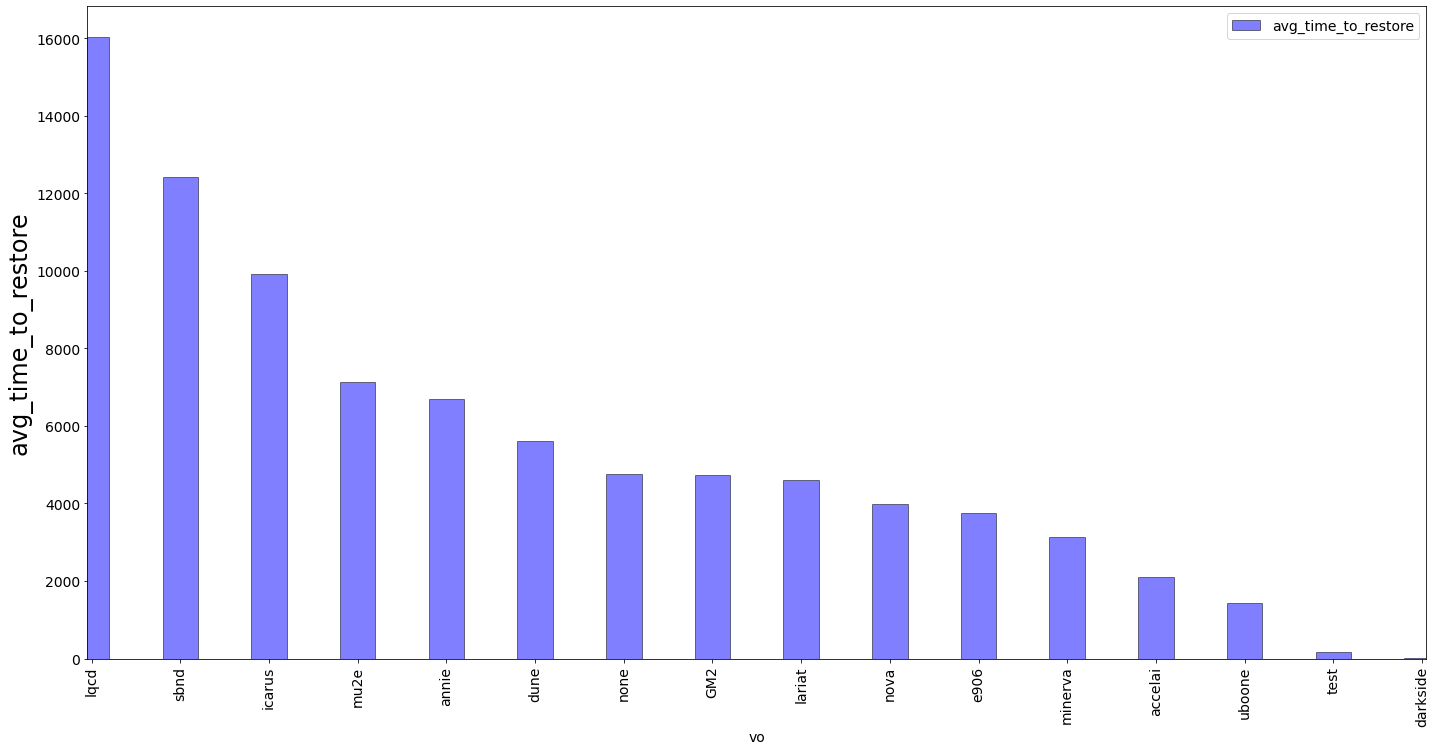

In [93]:
d1.plot.bar(x='vo', y='avg_time_to_restore' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("avg_time_to_restore" ,fontsize=24)
plt.savefig('avg_time_to_restore_per_vo.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()

In [7]:
# d6.plot.bar(x='vo', y='time_to_restore' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
# plt.xlabel("vo")
# plt.ylabel("time_to_restore" ,fontsize=24)
# #plt.savefig('time_to_restore_per_vo.png' ,fontsize=24)
# plt.rcParams.update({'font.size': 14})
# plt.xticks(rotation=90)
# plt.show()

In [97]:
df_vo_store = spark.sql("SELECT vo ,COUNT(vo) AS number_of_stores , AVG(connectiontime + queuedtime) as avg_time_to_store FROM billing WHERE action='store' and errorcode = 0 group by vo order by avg_time_to_store desc;  ")
df_vo_store.show()

+---------+----------------+--------------------+
|       vo|number_of_stores|   avg_time_to_store|
+---------+----------------+--------------------+
|    test2|               2|        6.16125935E7|
|   uboone|         4624815|2.7905730479529884E7|
|    e1039|              49|2.6853616591836736E7|
|      des|             320|   2.2973797209375E7|
|fermigrid|             119|2.2186708168067228E7|
|  accelai|            1381|2.0443625524981897E7|
|     nova|         1151983|2.0117794625717565E7|
|     dune|          162133| 1.873041246928756E7|
|      GM2|          464595| 1.839743353193211E7|
|    annie|           13871| 1.785159664047293E7|
|     test|            1469|1.5869564104152484E7|
|     mu2e|          126407| 1.269817436898273E7|
|   icarus|           75140|    9849622.21631621|
|   Simons|              29|   7305493.724137931|
|  snoplus|           11371|   5743502.669773987|
|  backups|               1|           4598508.0|
|     lqcd|            2822|  3170392.3036853294|


In [100]:
d2=df_vo_store.toPandas()
print(d2)

           vo  number_of_stores  avg_time_to_store
0       test2                 2       6.161259e+07
1      uboone           4624815       2.790573e+07
2       e1039                49       2.685362e+07
3         des               320       2.297380e+07
4   fermigrid               119       2.218671e+07
5     accelai              1381       2.044363e+07
6        nova           1151983       2.011779e+07
7        dune            162133       1.873041e+07
8         GM2            464595       1.839743e+07
9       annie             13871       1.785160e+07
10       test              1469       1.586956e+07
11       mu2e            126407       1.269817e+07
12     icarus             75140       9.849622e+06
13     Simons                29       7.305494e+06
14    snoplus             11371       5.743503e+06
15    backups                 1       4.598508e+06
16       lqcd              2822       3.170392e+06
17     lariat                 1       1.757057e+06
18       next             23774

In [101]:
d2['avg_time_to_store']=d2['avg_time_to_store'].div(1000)
print(d2)

           vo  number_of_stores  avg_time_to_store
0       test2                 2       61612.593500
1      uboone           4624815       27905.730480
2       e1039                49       26853.616592
3         des               320       22973.797209
4   fermigrid               119       22186.708168
5     accelai              1381       20443.625525
6        nova           1151983       20117.794626
7        dune            162133       18730.412469
8         GM2            464595       18397.433532
9       annie             13871       17851.596640
10       test              1469       15869.564104
11       mu2e            126407       12698.174369
12     icarus             75140        9849.622216
13     Simons                29        7305.493724
14    snoplus             11371        5743.502670
15    backups                 1        4598.508000
16       lqcd              2822        3170.392304
17     lariat                 1        1757.057000
18       next             23774

<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'avg_time_to_store')

/tmp/ipykernel_259211/2499800147.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('avg_time_to_store_per_vo.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'test2'),
  Text(1, 0, 'uboone'),
  Text(2, 0, 'e1039'),
  Text(3, 0, 'des'),
  Text(4, 0, 'fermigrid'),
  Text(5, 0, 'accelai'),
  Text(6, 0, 'nova'),
  Text(7, 0, 'dune'),
  Text(8, 0, 'GM2'),
  Text(9, 0, 'annie'),
  Text(10, 0, 'test'),
  Text(11, 0, 'mu2e'),
  Text(12, 0, 'icarus'),
  Text(13, 0, 'Simons'),
  Text(14, 0, 'snoplus'),
  Text(15, 0, 'backups'),
  Text(16, 0, 'lqcd'),
  Text(17, 0, 'lariat'),
  Text(18, 0, 'next'),
  Text(19, 0, 'darkside')])

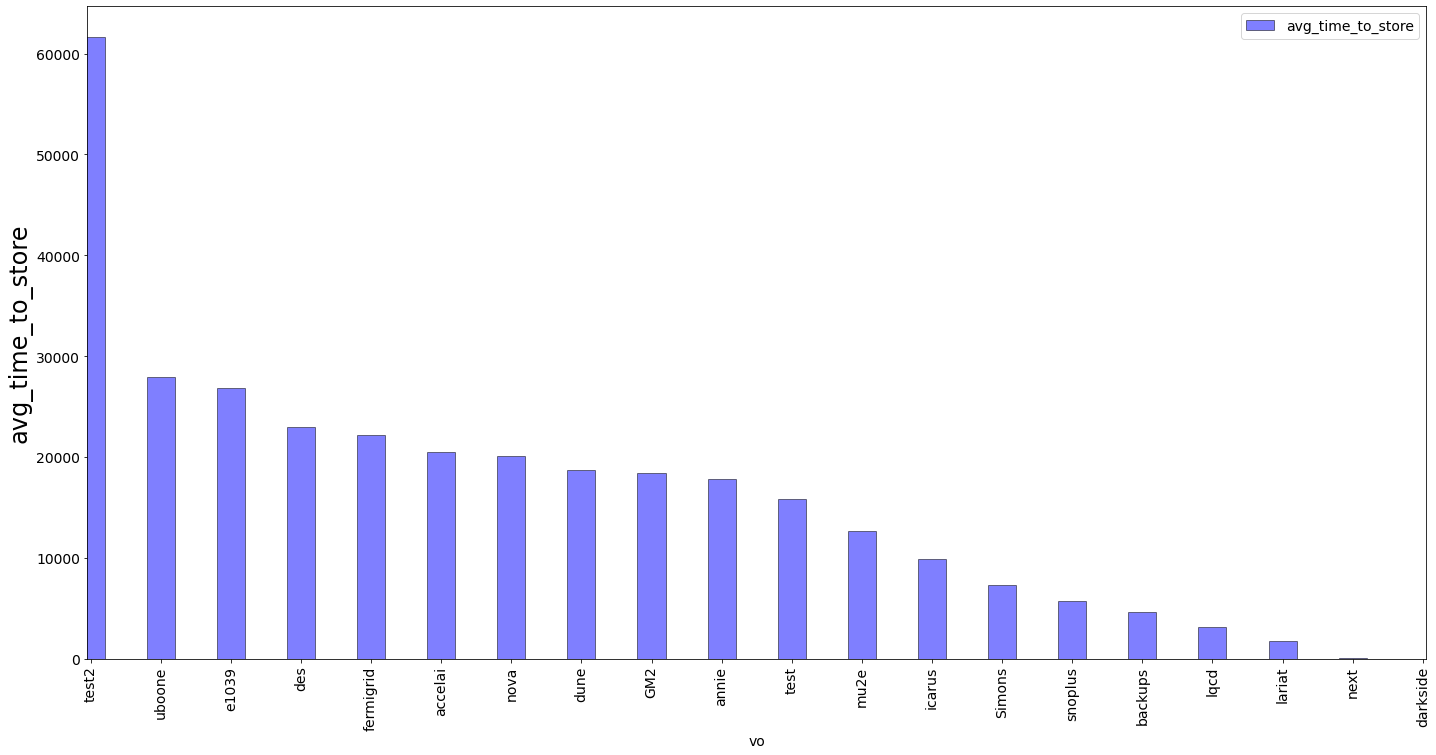

In [102]:
d2.plot.bar(x='vo', y='avg_time_to_store' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("avg_time_to_store" ,fontsize=24)
plt.savefig('avg_time_to_store_per_vo.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()

In [103]:
#select avg(connectiontime+queuedtime)/1000. from storageinfo where errorcode = 0 and datestamp > '2022-06-01 00:00:00'  and storageclass like 'GM2%' and action = 'restore';

In [104]:
df_vo_mu2e = spark.sql("SELECT date, vo , (connectiontime+queuedtime)/1000 as connection_time FROM billing WHERE action='restore' and errorcode = 0 and vo='mu2e' group by date, vo, connection_time order by connection_time desc;  ")
df_vo_mu2e.show()

+-------------------+----+---------------+
|               date|  vo|connection_time|
+-------------------+----+---------------+
|2022-06-22 08:00:00|mu2e|      68398.906|
|2022-06-22 08:00:00|mu2e|      66693.288|
|2022-06-22 08:00:00|mu2e|      66203.092|
|2022-06-22 08:00:00|mu2e|      66181.966|
|2022-06-22 10:00:00|mu2e|      66178.996|
|2022-06-22 08:00:00|mu2e|      65444.544|
|2022-06-22 10:00:00|mu2e|      65392.703|
|2022-06-22 10:00:00|mu2e|      65044.271|
|2022-06-22 11:00:00|mu2e|      64416.178|
|2022-06-22 08:00:00|mu2e|      63843.119|
|2022-06-22 11:00:00|mu2e|       62581.29|
|2022-06-22 10:00:00|mu2e|      61120.264|
|2022-06-22 08:00:00|mu2e|      60852.228|
|2022-06-22 07:00:00|mu2e|      60670.884|
|2022-06-22 08:00:00|mu2e|      60235.976|
|2022-06-22 10:00:00|mu2e|      60059.921|
|2022-06-22 08:00:00|mu2e|      59681.703|
|2022-06-22 10:00:00|mu2e|      59570.083|
|2022-06-22 10:00:00|mu2e|      59449.405|
|2022-06-22 10:00:00|mu2e|      59415.693|
+----------

In [108]:
df_vo11 = spark.sql("SELECT date, vo , (connectiontime+queuedtime)/1000 as connection_time FROM billing WHERE action='restore' and errorcode = 0 and vo='mu2e' group by date, vo, connection_time   ")
df_vo11.show()

+-------------------+----+---------------+
|               date|  vo|connection_time|
+-------------------+----+---------------+
|2022-06-06 11:00:00|mu2e|          1.903|
|2022-06-06 09:00:00|mu2e|         32.539|
|2022-06-06 11:00:00|mu2e|         34.606|
|2022-06-06 11:00:00|mu2e|         11.162|
|2022-06-06 11:00:00|mu2e|          1.733|
|2022-06-06 10:00:00|mu2e|         10.778|
|2022-06-06 11:00:00|mu2e|         33.197|
|2022-06-06 09:00:00|mu2e|         24.641|
|2022-06-06 11:00:00|mu2e|         16.028|
|2022-06-06 11:00:00|mu2e|          3.391|
|2022-06-06 11:00:00|mu2e|          28.59|
|2022-06-06 11:00:00|mu2e|          1.574|
|2022-06-06 11:00:00|mu2e|         13.695|
|2022-06-06 11:00:00|mu2e|          6.642|
|2022-06-06 10:00:00|mu2e|         54.418|
|2022-06-06 10:00:00|mu2e|         43.849|
|2022-06-06 10:00:00|mu2e|         18.864|
|2022-06-06 10:00:00|mu2e|         17.205|
|2022-06-06 09:00:00|mu2e|          1.543|
|2022-06-06 11:00:00|mu2e|         41.367|
+----------

In [105]:
df_vo_mu2e.count()

17699

In [109]:
d3=df_vo11.toPandas()
print(d3)

                     date    vo  connection_time
0     2022-06-04 15:00:00  mu2e         7198.893
1     2022-06-04 15:00:00  mu2e         6537.027
2     2022-06-04 15:00:00  mu2e         2319.462
3     2022-06-03 10:00:00  mu2e           11.068
4     2022-06-03 13:00:00  mu2e         9232.206
5     2022-06-03 13:00:00  mu2e            1.199
6     2022-06-03 13:00:00  mu2e           10.532
7     2022-06-03 14:00:00  mu2e            7.475
8     2022-06-03 15:00:00  mu2e         1231.758
9     2022-06-03 15:00:00  mu2e         5298.156
10    2022-06-04 15:00:00  mu2e         8394.372
11    2022-06-03 14:00:00  mu2e         9523.176
12    2022-06-04 15:00:00  mu2e         2230.362
13    2022-06-03 13:00:00  mu2e           25.181
14    2022-06-03 13:00:00  mu2e            8.576
15    2022-06-04 14:00:00  mu2e          915.269
16    2022-06-03 14:00:00  mu2e         2394.107
17    2022-06-03 10:00:00  mu2e           15.179
18    2022-06-03 14:00:00  mu2e           99.154
19    2022-06-04 15:

In [106]:
d4=df_vo_mu2e.toPandas()
print(d4)

                     date    vo  connection_time
0     2022-06-22 08:00:00  mu2e        68398.906
1     2022-06-22 08:00:00  mu2e        66693.288
2     2022-06-22 08:00:00  mu2e        66203.092
3     2022-06-22 08:00:00  mu2e        66181.966
4     2022-06-22 10:00:00  mu2e        66178.996
5     2022-06-22 08:00:00  mu2e        65444.544
6     2022-06-22 10:00:00  mu2e        65392.703
7     2022-06-22 10:00:00  mu2e        65044.271
8     2022-06-22 11:00:00  mu2e        64416.178
9     2022-06-22 08:00:00  mu2e        63843.119
10    2022-06-22 11:00:00  mu2e        62581.290
11    2022-06-22 10:00:00  mu2e        61120.264
12    2022-06-22 08:00:00  mu2e        60852.228
13    2022-06-22 07:00:00  mu2e        60670.884
14    2022-06-22 08:00:00  mu2e        60235.976
15    2022-06-22 10:00:00  mu2e        60059.921
16    2022-06-22 08:00:00  mu2e        59681.703
17    2022-06-22 10:00:00  mu2e        59570.083
18    2022-06-22 10:00:00  mu2e        59449.405
19    2022-06-22 10:

In [146]:
print(d4['connection_time'].max())

68398.906


Text(0.5, 0, 'time_to_restore')

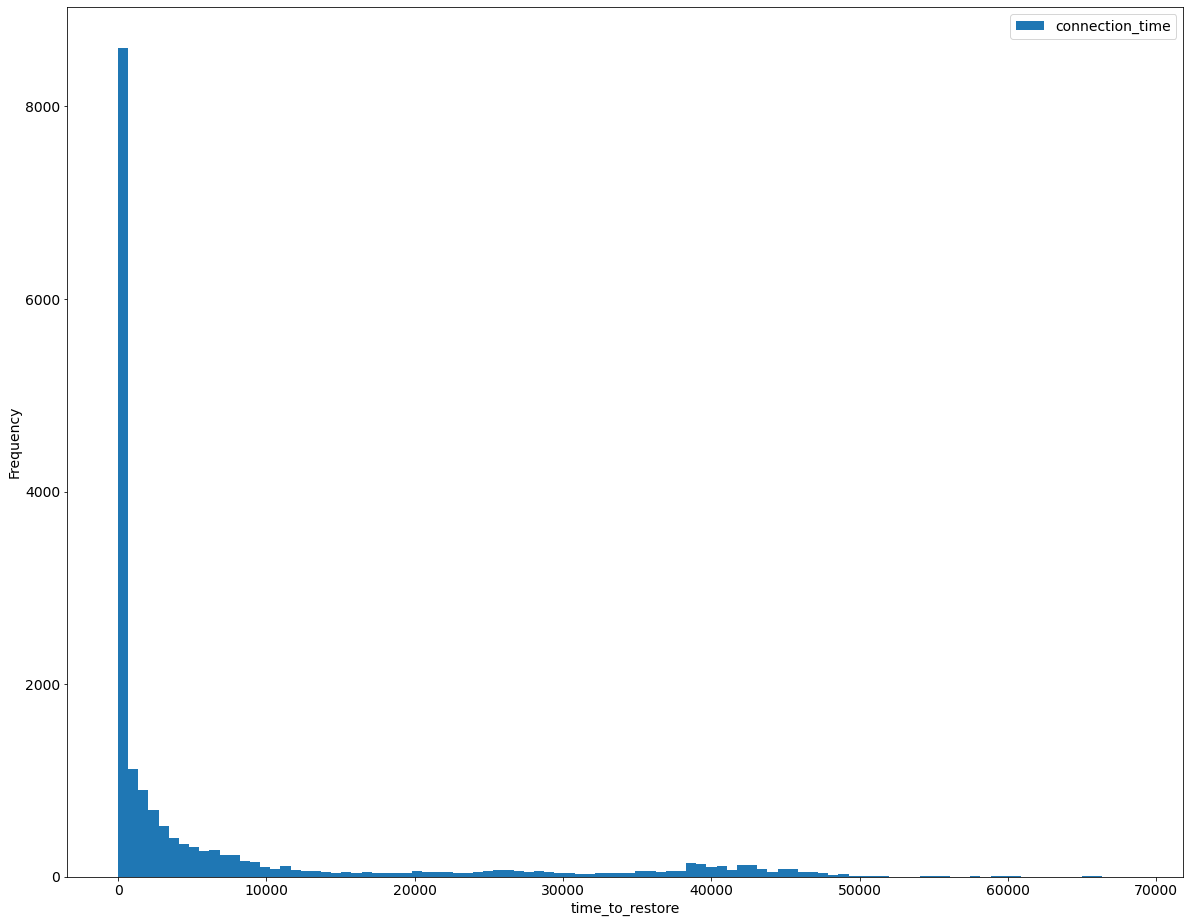

In [110]:
ax= d3.plot.hist(bins=100, figsize=(20, 16))
plt.xlabel("time_to_restore")
plt.savefig('hist_time_to_restore_for_mu2e.png')

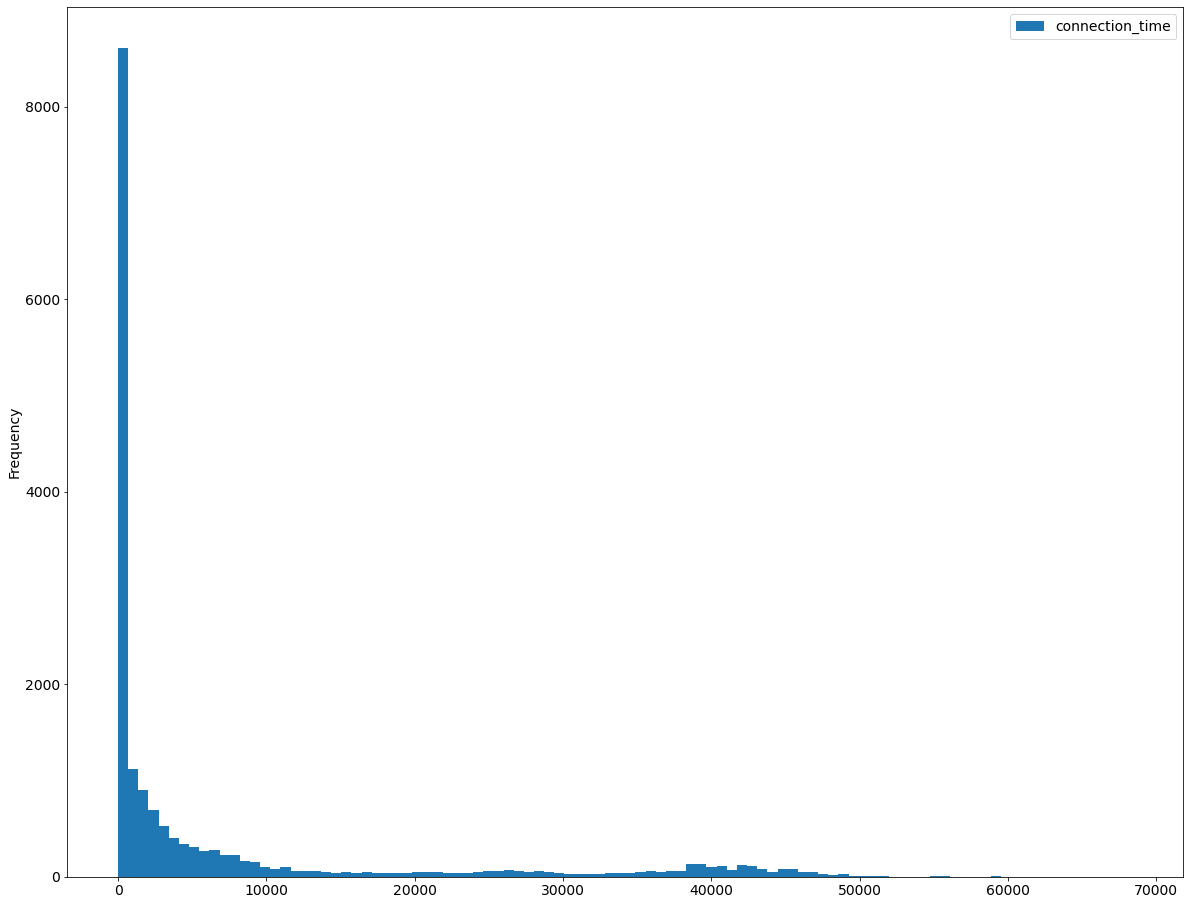

In [107]:
ax= d4.plot.hist(bins=100, figsize=(20, 16))
#plt.xlim(0, 68398.906)